In [1]:
import model
import numpy as np
import random
import tank
import truck

import gym_pdsystem

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import animation, rc
import matplotlib.patches as mpatches

from IPython.display import HTML

import pandas as pd
import time

from gym_pdsystem.envs.pdsystem_env import PDSystemEnv
import gym_pdsystem.utils.utilsq as ut
import gym_pdsystem.utils.constants as ct
import gym_pdsystem.utils.functions as fnc

import os

simulations_directory = './simulations'
if not os.path.exists(simulations_directory):
    os.makedirs(simulations_directory)


In [2]:
COEFF = ct.COEFF

C_TRANSPORT = ct.C_TRANSPORT
C_LEVELS = ct.C_LEVELS

p0_GLOBAL = ct.p0_GLOBAL

P1_GLOBAL = ct.P1_GLOBAL
P2_GLOBAL = ct.P2_GLOBAL

M_GLOBAL = ct.M_GLOBAL

NOT_DELIVERYING_PENALTY = P2_GLOBAL #to be equivalent/same importance as having 0 stock or surpassing max capacity levels


## System initializer

In [3]:
def initialize_test_system(noise = False, seed = None):
    if seed != None:
        np.random.seed(seed)

    # Tanks' information
    global n
    n = 5 
    tank_ids = list(range(1,n+1))
    tank_max_loads =  np.array([100., 200, 100., 800., 200.])
    C_max = np.array([ [load] for load in tank_max_loads ])

    tank_current_loads = np.full(n,0)
    tank_consumption_rates =  np.array([5.] * n)
    noisy_consumption_rate = noise
    
    global n_discrete_load_levels
    n_discrete_load_levels = np.array([4,4,4,4,4])
    
    load_level_percentages = np.array([ #b , c, e
                                            [0.02, 0.31, 0.9],
                                            [0.01, 0.03, 0.9],
                                            [0.05, 0.16, 0.9],
                                            [0.07, 0.14, 0.85],
                                            [0.08, 0.26, 0.9]
                                               ])
    for i in range(n):
        tank_consumption_rates[i] = tank_max_loads[i] * (load_level_percentages[i][0] + load_level_percentages[i][1])/2.0
        
    tank_levels = np.multiply(C_max,load_level_percentages)
    
    for i, tank_level in enumerate(tank_levels):
                a = tank_level[0]
                b = tank_level[-1]
                #current_load = 0.75 * (a+b)/2.0# np.random.randint(a+1,b, size =(1,)) GIVES A STRANGE ERROR
                current_load = np.random.random() * (b - a-1) + a+1 #np.random.randint(a+1,b)
                tank_current_loads[i] = current_load * 1.0
                
#     for i, (lvl, max_load) in enumerate(zip(n_discrete_load_levels, tank_max_loads)):
#         a = np.linspace(0,max_load, lvl+1)[1]
#         current_load = np.random.randint(a+1,max_load)
#         tank_current_loads[i] = current_load     

    # Trucks' information
    global k
    k = 2
    truck_ids = list(range(k))
    truck_max_loads = np.array([70.,130.])
    truck_current_loads = truck_max_loads.copy()
    truck_current_positions =  np.array([5] * k)
    #truck_fractions_deliverable =  np.array([1.] * k) # we for now we only allow to deliver all the content of the truck
    truck_fractions_deliverable =  np.array([ np.array([1.]), 
                                              np.array([1.])
                                            ]) # we for now we only allow to deliver all the content of the truck
    global n_discrete_load_levels_trucks
    n_discrete_load_levels_trucks = np.array([1,1])

    # System's information
   
    graph = ut.simple_graph(n+1)
    tanks = [tank.Tank( tank_id, current_load, max_load, consumption_rate, n_lvls, d_lvls, noisy_consumption_rate) 
             for  tank_id, current_load, max_load, consumption_rate, n_lvls, d_lvls in 
             zip( tank_ids, tank_current_loads, tank_max_loads, tank_consumption_rates, n_discrete_load_levels,
                  load_level_percentages)]
    trucks = [truck.Truck( truck_id, current_load, max_load, current_position, load_fractions_deliverable, n_lvls) 
             for  truck_id, current_load, max_load, current_position, load_fractions_deliverable, n_lvls in 
             zip(truck_ids, truck_current_loads, truck_max_loads, truck_current_positions, 
                 truck_fractions_deliverable, n_discrete_load_levels_trucks)]

    w =  np.array([32., 159., 162., 156.,156., 0.])

    weights_matrix = ut.simple_weights(n+1, w)
    
    return(tanks, trucks, graph, weights_matrix)

tanks, trucks, graph, weights_matrix = initialize_test_system()
toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

# Action-State space dimension
a_s_dim = toy_system.states_dim * toy_system.actions_dim
a_s_dim

368640

In [4]:
tanks, trucks, graph, weights_matrix = initialize_test_system(seed = 42)
system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)
print(system.tank_loads())
print(system.graph)
print(system.weights)

[35, 171, 67, 429, 42]
[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [1 1 1 1 1 1]]
[[ inf  inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf  inf]
 [ inf  inf  inf  inf  inf  inf]
 [ 32. 159. 162. 156. 156.   0.]]


### Reinitialize system function

In [5]:
def reinitialize_system(system, seed = None):
    if seed != None:
        np.random.seed(seed)
        
    for tank, tank_levels in zip(system.tanks, system.tanks_level):
        a = tank_levels[0]
        b = tank_levels[-1]
        current_load = np.random.random() * (b - a-1) + a+1 #np.random.randint(a+1,b)*1.0
        tank.load = current_load
    system.reset_trucks_positions(); 
    return(system)    

## Q-learning algorithm (off-policy)


### Training

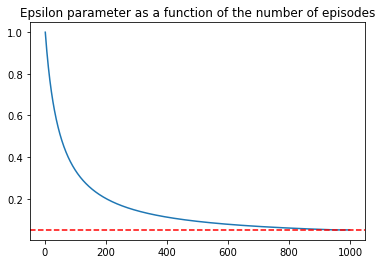

In [6]:
# Retrain parameters:
retrain = False

episode_retrain = 2*10**3 # episode number from which start the retrain. Ensure that a file with this number in 
                          # the Q filename is available.
retrain_episodes = 1*10**3


# Train parameters:
train_epsilon = True

learning_rate0 = 1 
learning_rate_decay = 0 

episode_length = 30
discount_rate = 0.9

episodes = 10**3
episodes_epsilon_min = 0.05*episodes

# Output's frequencies
train_freq = 10**2 # 10**4
train_vis_freq =  np.inf #10**3
train_rew_freq =  10**2
train_Q_freq =  10**3 #3

epsilon0 = 1.0
epsilon_decay =( 1./(episodes_epsilon_min) ) 
epsilon_min = 0.05

verbose = False
verbose_info = False

seed = 42

simulation_id = 27
add_noise = False

# Visualization of the epsilon parameter value that will be present duing the simulation
% matplotlib inline

def epsilon_fnc(x, epsilon0 = epsilon0, decay = epsilon_decay, epsilon_min = epsilon_min):
    e_mins = epsilon_min * np.ones(len(x))
    eps = epsilon0 / (1.0 + (x-1)*epsilon_decay)
    return np.maximum(e_mins, eps )

t = np.arange(1, episodes, 1)
epsilon = epsilon_fnc(t)

plt.plot(t, epsilon)
plt.axhline(y= epsilon_min, xmin=0, xmax=episodes, hold=None, color = "Red", linestyle = '--')

plt.title("Epsilon parameter as a function of the number of episodes");

In [7]:
train_visualization_steps = []
train_rewards_list = []

tanks, trucks, graph, weights_matrix = initialize_test_system(noise = add_noise, seed = seed)
toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

Q = {}

# Create directories for the simulations' outputs

simulation_directory = './simulations/simulation{}'.format(simulation_id)
rewards_file = simulation_directory+'/discrewards'+ '/rewards-sim{}.csv'.format(simulation_id)
states_file = simulation_directory+'/vis'+ '/states-sim{}.csv'.format(simulation_id) # for testing

if not os.path.exists(simulation_directory):
    os.makedirs(simulation_directory)
    os.makedirs(simulation_directory + '/Q-dictionaries')
    os.makedirs(simulation_directory + '/discrewards')
    os.makedirs(simulation_directory + '/vis')
    
else:
    raise Exception("The simulation id you tried to use has been already used before. Try to change it to a new one.")

    
ut.save_obj(toy_system, simulation_directory+"/system-sim"+"{}".format(simulation_id)) 

# Output headers to file
with open(rewards_file,'w') as f:
     np.savetxt(f, [["episode", "discreward"]], fmt="%s", delimiter=',')         


In [8]:
def episodic_train_Q_epsilon( 
            epsilon0 = epsilon0,
            epsilon_min = epsilon_min,
            n_episodes = episodes, 
            episode_length = episode_length,
            learning_rate0 = learning_rate0,
            learning_rate_decay = learning_rate_decay,
            discount_rate = discount_rate,
            system = toy_system,
            Q = Q, verbose = verbose, verbose_info = verbose_info,
            visualization_steps = train_visualization_steps, rewards_list = train_rewards_list,
            seed = seed, 
            freq = train_freq,
            vis_freq = train_vis_freq,
            rew_freq = train_rew_freq,
            Q_freq = train_Q_freq,
            simulation_id = simulation_id,
            round_time = 2
    
           ):
    
    time_start = time.time()
    
    for episode in range(1,n_episodes+1):
        print("\rEpisode: {}".format(episode), end="")

        reinitialize_system(system, seed = episode)
        
        ### epsilon-greedy exploration
        epsilon = max( epsilon_min, epsilon0 / (1+(episode-1)*epsilon_decay) ) 
        
        ### decrement of learning rate
        learning_rate = learning_rate0 / (1+(episode-1)*learning_rate_decay)        

        discounted_reward = 0
        
        for t in range(episode_length):

            system.update_state()
            s_current = system.state_to_string()                
            p = np.random.uniform()

            if p > epsilon:
                #DETERMINISTIC ACTION OPTIMAL
                s0 = system.state_to_string()
                best_action = optimal_policy(s0, Q)
                if best_action == None:
                    reward, _,_ = system.random_action(seed = (seed + (t+1)*episode), verbose = verbose)
                else:
                    reward, _ ,_ = system.deterministic_action(best_action)
                #print(best_action)
            else:
                reward,_ ,_ = system.random_action(seed = (seed + (t+1)*episode), verbose = verbose)

            a_current = system.action_to_string()
            sa_current = ''.join([s_current, a_current])

            system.update_state()
            sa_new = system.state_action_to_string()

            if ut.is_key(Q, sa_current) == False:
                Q[sa_current] = 0

            Q_max = max([Q[key] for key in Q.keys() if key.startswith(sa_new[0:system.state_length])]+[0.0]) 

            if Q[sa_current] != -np.inf:
                Q[sa_current] = ( (1-learning_rate) * Q[sa_current] 
                                 + learning_rate* (reward + discount_rate * Q_max)
                                )
                
            discounted_reward = discounted_reward + (discount_rate**t) * reward
            system.reset_trucks_positions();     
            system.reset_trucks_loads();
            
        #rewards_list.append(discounted_reward);
        if episode % freq == 0:
                time_end = time.time()
                print(". Elapsed time ", round( (time_end-time_start)/60., round_time), " minuts.",
                      "epsilon", round(epsilon,4), 
                     "Discounted reward: ", discounted_reward)
                
                if verbose_info:
                    print("s, a", system.s, system.a)
                    print("ds, da", system.ds, system.da)
        if episode % Q_freq == 0:           
                ut.save_obj(Q, simulation_directory +"/Q-dictionaries/Q-dict-sim" + "{}".format(simulation_id) + "-" + "{}".format(episode))   

        if episode % vis_freq == 0:
                #Save visualization and rewards
                visualization_steps.append(toy_system.visualize());
                ut.save_obj(visualization_steps, simulation_directory +"/vis/vis-train-sim" + "{}".format(simulation_id) + "-" + "{}".format(episode))   
                                
        if episode % rew_freq == 0:
                #rewards_list.append(discounted_reward);
                #ut.save_obj(rewards_list, simulation_directory +"/discrewards/discrew-train-sim" + f"{simulation_id}" + "-" + f"{episode}")
                # Output data to files
                with open(rewards_file,'ab') as f:
                    np.savetxt(f, [np.array([episode, discounted_reward])], fmt=("%d",'%.10f'), delimiter=',')    
        
    end_time = round(time.time()-time_start,round_time)        
    print("Training finished. Total episodes: {}. Elapsed time: {} minutes.".format(n_episodes,round(end_time/60., round_time)))        

In [9]:
# Given a state, returns the action that has the highest Q-value.

def optimal_policy(state, Q, system = toy_system):
    """
    state must be in the string-integers code
    """
    state_keys = [key for key in list(Q) if key.startswith(state)]
    if len(state_keys) == 0:
        return(None)
    
    state_q = [Q[state_key] for state_key in state_keys]
    
    #print("state_q ", state_q[1:min(10,len(state_q))])
    
    max_q = max(state_q)
    #print("max_q", max_q)
    optimal_key_index = np.where(np.isin(state_q, max_q ))[0][0]
    #print("optimal_key_index", optimal_key_index)
    optimal_key = state_keys[optimal_key_index]
    #print("optimal_key", optimal_key)
    optimal_action = optimal_key[system.state_length:]
    
    return(optimal_action)
    

In [10]:
if train_epsilon == True and retrain == False:
    episodic_train_Q_epsilon()
elif train_epsilon == False and retrain == True:
    Q_retrain = ut.load_obj(simulation_directory + "/Q-dictionaries/Q-dict-sim" + "{}".format(simulation_id) + "-" + "{}".format(episode_retrain))
    episodic_train_Q_epsilon(n_episodes = retrain_episodes, Q = Q_retrain)
else:
    raise Exception("Only one of the parameters train_epsilon or retrain parameters can be set to True.")
    

Episode: 100. Elapsed time  0.05  minuts. epsilon 0.3356 Discounted reward:  -11.737553909895604
Episode: 200. Elapsed time  0.11  minuts. epsilon 0.2008 Discounted reward:  -6.578840434105677
Episode: 300. Elapsed time  0.19  minuts. epsilon 0.1433 Discounted reward:  -5.0775008978911185
Episode: 400. Elapsed time  0.27  minuts. epsilon 0.1114 Discounted reward:  -6.844288526009088
Episode: 500. Elapsed time  0.35  minuts. epsilon 0.0911 Discounted reward:  -6.194897967810197
Episode: 600. Elapsed time  0.43  minuts. epsilon 0.077 Discounted reward:  -4.393913106977852
Episode: 700. Elapsed time  0.53  minuts. epsilon 0.0668 Discounted reward:  -6.089048262308218
Episode: 800. Elapsed time  0.62  minuts. epsilon 0.0589 Discounted reward:  -3.0176417103024313
Episode: 900. Elapsed time  0.71  minuts. epsilon 0.0527 Discounted reward:  -3.5060235308758094
Episode: 1000. Elapsed time  0.81  minuts. epsilon 0.05 Discounted reward:  -6.9593849767032685
Training finished. Total episodes: 10

### Testing

In [11]:
# TEST PARAMETERS AND INITIALIZATION

# Initialize system
#episodes = 100000#243000
#simulation_id = 16 # comment when training
#simulation_directory = './simulations/simulation{}'.format(simulation_id) # comment when training


tanks, trucks, graph, weights_matrix = initialize_test_system(seed =episodes+1)
test_toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

Q = ut.load_obj(simulation_directory + "/Q-dictionaries/Q-dict-sim" + "{}".format(simulation_id) + "-" + "{}".format(episodes))


test_episodes = 5
episode_length =30
test_freq = 1
test_verbose = False

test_visualization_steps = []
test_rewards_list = []
test_level_rewards_list = []
test_transport_rewards_list = []
test_trucks_sent_list = []
test_number_of_first_trucks_sent_list = []
test_number_of_second_trucks_sent_list = []

In [12]:
with open(states_file,'w') as f:
     np.savetxt(f, [["step", "stock0", "stock1", "stock2","stock3", "stock4"]], fmt="%s", delimiter=',')  


def test_Q(n_episodes = test_episodes, 
           episode_length = episode_length,
           system = test_toy_system,
           visualization_steps = test_visualization_steps, 
           rewards_list = test_rewards_list,
           level_rewards_list = test_level_rewards_list,
           transport_rewards_list = test_transport_rewards_list,
           trucks_sent_list = test_trucks_sent_list,
           number_of_first_trucks_sent_list =test_number_of_first_trucks_sent_list,
           number_of_second_trucks_sent_list = test_number_of_second_trucks_sent_list,
           freq = test_freq,
           test_verbose = test_verbose ,
           states_file = states_file, 
           Q = Q
          ):
    
    for episode in range(1,n_episodes+1): 
        print("\rTest episode: {}\n".format(episode), end="")
        reinitialize_system(system, seed = episode+episodes)

        discounted_reward = 0 
        transport_rewards = 0
        level_rewards = 0
        number_of_trucks_sent = 0
        number_of_first_trucks_sent = np.zeros(n+1, dtype = np.int64)
        number_of_second_trucks_sent = np.zeros(n+1, dtype = np.int64)

        
        for i in range(1,episode_length+1):
            #print("state", test_toy_system.s, test_toy_system.ds)
            system.update_state()

            #Save visualization steps
            if i % freq == 0:
                visualization_steps.append(system.visualize());
                state = system.state()
#                 print(state[2])
#                 print([i]+state[2])
                with open(states_file,'ab') as f:
                    np.savetxt(f, [np.array([(episode-1)*(episode_length)+i]+state[2])], fmt=("%d",'%.3f','%.3f','%.3f','%.3f','%.3f'), delimiter=',')    

            s0 = system.state_to_string()
            best_action = optimal_policy(s0, Q)
            #print("best_action", best_action)

            if best_action == None:
                reward, transport_reward, level_reward = system.random_action()
                if i % freq == 0:
                    if test_verbose == True:
                        print("Episode", episode, "t", i-1, round(reward,7), round(level_reward,7), round(transport_reward,7), "\nRandom action is performed. Current state unknown for Q.")

            else:
                reward, transport_reward, level_reward = system.deterministic_action(best_action)
                number_of_trucks_sent = number_of_trucks_sent + best_action.count('5')
                index1 = int(best_action[0])
                number_of_first_trucks_sent[index1] = number_of_first_trucks_sent[index1] + 1
                index2 = int(best_action[1])
                number_of_second_trucks_sent[index2] = number_of_second_trucks_sent[index2] + 1
                
                if i % freq == 0:
                    if test_verbose == True:
                        print("Episode", episode, "t",i-1,round(reward,7),round(level_reward,7), round(transport_reward,7), best_action)

            system.reset_trucks_positions();
            system.reset_trucks_loads();
            
            discounted_reward = discounted_reward + (discount_rate**(i-1)) * reward
            transport_rewards = transport_rewards+transport_reward
            level_rewards = level_rewards + level_reward
            
            if reward <= P2_GLOBAL:
                print("\rSome tank is in a forbidden level")

        system.reset_trucks_positions();
        
        #Save rewards
        if episode % freq == 0:
            rewards_list.append(discounted_reward);
            transport_rewards_list.append(transport_rewards);
            level_rewards_list.append(level_rewards);
            trucks_sent_list.append(episode_length * system.k - number_of_trucks_sent);
            number_of_first_trucks_sent_list.append(number_of_first_trucks_sent);
            number_of_second_trucks_sent_list.append(number_of_second_trucks_sent);






Test episode: 1
Test episode: 2
Test episode: 3
Test episode: 4
Test episode: 5


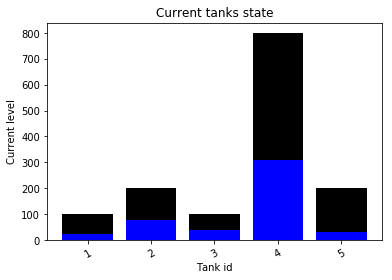

In [13]:
test_Q()
#print(np.mean(test_rewards_list) )

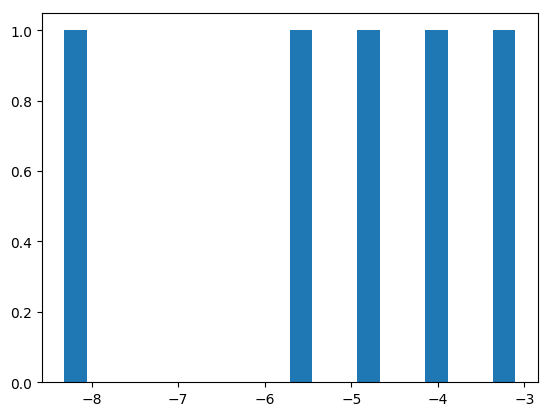

In [14]:
%matplotlib inline
mpl.rcParams.update(mpl.rcParamsDefault)
plt.hist(test_rewards_list, bins = 20)
plt.show()

In [15]:
# Visualizing test simulation:

# test_anim = ut.create_system_animation(test_visualization_steps, test_episodes * episode_length,test_freq)
# HTML(test_anim.to_html5_video())


/home/dsalgador/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:696: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


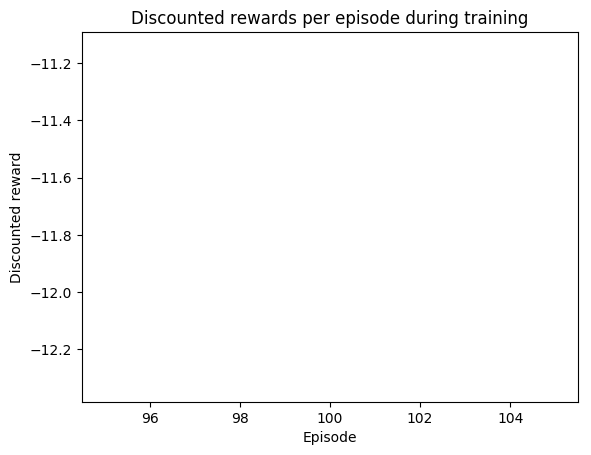

In [16]:
# Visualizing train simulation:

episode =episodes
#simulation_id = 2
step = 30
# discrewards_list = ut.load_obj(simulation_directory+"/discrewards/discrew-train-sim" + f"{simulation_id}" + "-" + f"{episode}")

# discrewards_list2 = [discrewards_list[i] for i in range(0,len(discrewards_list),step)]

# p = plt.plot([i for i in range(0,len(discrewards_list),step)], 
#              discrewards_list2)
# plt.savefig(simulation_directory+'/discrewards-sim' + f'{simulation_id}' + '.png')

discrewards = pd.read_table(rewards_file, sep = ",")

indices = [i for i in range(0,episodes,10)]

plt.plot(discrewards['episode'][indices],discrewards['discreward'][indices], label = "Discounted rewards")
plt.title("Discounted rewards per episode during training")
plt.xlabel("Episode")
plt.ylabel("Discounted reward")

plt.show()
plt.close()


In [17]:
discrewards['episode'][ [i for i in range(10)]]

0     100
1     200
2     300
3     400
4     500
5     600
6     700
7     800
8     900
9    1000
Name: episode, dtype: int64

In [18]:
len(list(Q))

3675

In [19]:
tank_levels = [test_visualization_steps[i][2] for i in range(len(test_visualization_steps))]
tank_levels_array = np.asarray(tank_levels).transpose()

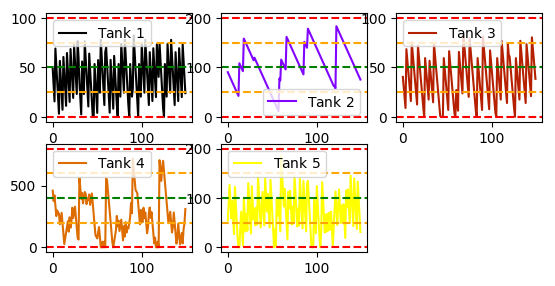

In [20]:
#DISCRETE LEVELS

cmap = plt.get_cmap('gnuplot')
colors = [cmap(i) for i in np.linspace(0, 1, n)]
lvl_colors = ["Orange", "Green","Orange"]

tanks = test_toy_system.tanks

for i, color in enumerate(colors, start=1):
    plt.subplot(3,3, i)    
    plt.plot(tank_levels_array[i-1], color=color, label='Tank ${i}$'.format(i=i))
    
    plt.axhline(y= tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')
    for lvl_color, lvl in zip(lvl_colors, tanks[i-1].levels):
        plt.axhline(y= lvl, xmin=0, xmax=episode_length, hold=None, color = lvl_color, linestyle = '--')
    plt.axhline(y= 0, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')


    plt.legend(loc='best')
plt.show()

        

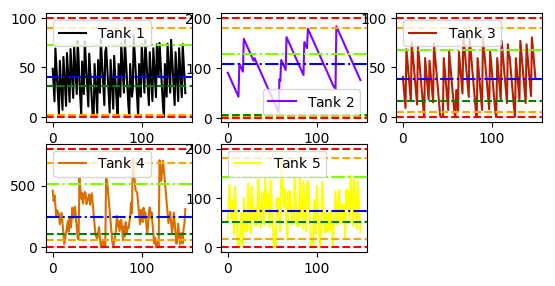

In [21]:
# THE REAL LEVELS (percentages 12h, 36h, ? h)

cmap = plt.get_cmap('gnuplot')
colors = [cmap(i) for i in np.linspace(0, 1, n)]
lvl_colors = ["Orange", "Green","Orange"]

tanks = test_toy_system.tanks

for i, color in enumerate(colors, start=1):
    plt.subplot(3,3, i)    

    plt.plot(tank_levels_array[i-1], color=color, label='Tank ${i}$'.format(i=i))
    
    plt.axhline(y= tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')
    for lvl_color, lvl in zip(lvl_colors, tanks[i-1].level_percentages):
        plt.axhline(y= lvl * tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = lvl_color, 
                    linestyle = '--')
    plt.axhline(y= 0, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')
    
    
    percentages = tanks[i-1].level_percentages           
    c = percentages[1]
    e = percentages[2]          
    d = ct.p0_GLOBAL*e+(1-ct.p0_GLOBAL)*c
    plt.axhline(y= d*tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = "lawngreen", 
                linestyle = '-.')

    plt.axhline(y= np.mean(tank_levels_array[i-1]), xmin=0, xmax=episode_length, hold=None, 
                color = "blue", linestyle = '-.')
  


    plt.legend(loc='best')
#plt.show()
plt.savefig(simulation_directory + '/tank-levels-sim' + '{}'.format(simulation_id) + '.pdf')

### Test visualization

In [22]:
def visualize_simulation(states_file,
                        test_toy_system,
                        simulation_id,
                        simulation_directory):
    test_states = pd.read_table(states_file, sep = ",")
    test_states.head()


    cmap = plt.get_cmap('gnuplot')
    colors = [cmap(i) for i in np.linspace(0, 1, n)]
    lvl_colors = ["Orange", "Green","Orange"]

    tanks = test_toy_system.tanks

    for i, color in enumerate(colors, start=1):    
        plt.subplot(2,3,i)
        states = test_states['stock{}'.format(i-1)]
        plt.plot(test_states['step'],states, label = "Shop {}".format(i-1), color = "Black")
        plt.title("Shop {}".format(i-1))

        plt.axhline(y= tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')
        for lvl_color, lvl in zip(lvl_colors, tanks[i-1].level_percentages):
            plt.axhline(y= lvl * tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = lvl_color, 
                        linestyle = '--')
        plt.axhline(y= 0, xmin=0, xmax=episode_length, hold=None, color = "Red", linestyle = '--')


        percentages = tanks[i-1].level_percentages           
        c = percentages[1]
        e = percentages[2]          
        d = ct.p0_GLOBAL*e+(1-ct.p0_GLOBAL)*c
        plt.axhline(y= d*tanks[i-1].max_load, xmin=0, xmax=episode_length, hold=None, color = "lawngreen", 
                    linestyle = '-.')

        plt.axhline(y= np.mean(states), xmin=0, xmax=episode_length, hold=None, 
                    color = "blue", linestyle = '-.')
        plt.xticks(range(0,episode_length+1,5))


    plt.subplot(2,3,6)
    plt.title("Legend")
    plt.axis('off')

    #plt.legend(bbox_to_anchor=(0.5 ,0.8), loc=2, borderaxespad=0.)
    plt.yticks([])
    plt.xticks([])

    patch1 = mpatches.Patch(color='red', label='Max/Min capacities', linestyle = '--', fill = False, linewidth = 2)
    patch2 = mpatches.Patch(color='orange', label='Max/Min levels', linestyle = '--', fill = False, linewidth = 2)
    patch3 = mpatches.Patch(color='green', label='Danger level', linestyle = '--', fill = False, linewidth = 2)
    patch4 = mpatches.Patch(color='lawngreen', label='Max reward level (M)', linestyle = '-.', fill = False, linewidth = 2)
    patch5 = mpatches.Patch(color='blue', label='Observed mean level', linestyle = '-.', fill = False, linewidth = 2)
    patch6 = mpatches.Patch(color='black', label='Current stock level', linestyle = '-', fill = False, linewidth = 2)


    plt.legend(handles=[patch1, patch2, patch3, patch4, patch5, patch6], loc = 'center')

    plt.tight_layout() 
    plt.savefig(simulation_directory + '/tank-levels-sim' + '{}'.format(simulation_id) + '.pdf')
    plt.show()
    plt.close()


## Simulations

In [23]:

def test_simulation(simulation_id,
                   max_episodes,
                   n_episodes = 1,
                   noise = False):
    
    # Initialize directories and files
    
    simulation_directory = './simulations/simulation{}'.format(simulation_id)
    rewards_file = simulation_directory+'/discrewards'+ '/rewards-sim{}.csv'.format(simulation_id)
    states_file = simulation_directory+'/vis'+ '/states-sim{}.csv'.format(simulation_id) # for testing
    
    with open(states_file,'w') as f:
         np.savetxt(f, [["step", "stock0", "stock1", "stock2","stock3", "stock4"]], fmt="%s", delimiter=',') 

    # Initialize system
    episodes = max_episodes#100000

    tanks, trucks, graph, weights_matrix = initialize_test_system(noise, seed =episodes+1)
    test_toy_system = model.System(tanks = tanks, trucks = trucks, adjacency_matrix = graph, weights_matrix = weights_matrix)

    Q = ut.load_obj(simulation_directory + "/Q-dictionaries/Q-dict-sim" + "{}".format(simulation_id) + "-" + "{}".format(episodes))


    test_episodes = n_episodes
    episode_length =30
    test_freq = 1
    test_verbose = True

    test_visualization_steps = []
    test_rewards_list = []
    test_level_rewards_list = []
    test_transport_rewards_list = []
    test_trucks_sent_list = []
    test_number_of_first_trucks_sent_list = []
    test_number_of_second_trucks_sent_list = []
    
        
    test_Q(n_episodes = test_episodes, 
           episode_length = episode_length,
           system = test_toy_system,
           visualization_steps = test_visualization_steps, 
           rewards_list = test_rewards_list,
           level_rewards_list = test_level_rewards_list,
           transport_rewards_list = test_transport_rewards_list,
           trucks_sent_list = test_trucks_sent_list,
           number_of_first_trucks_sent_list = test_number_of_first_trucks_sent_list,           
           number_of_second_trucks_sent_list=test_number_of_second_trucks_sent_list,           
           freq = test_freq,
           test_verbose = test_verbose ,
           states_file = states_file, 
           Q = Q 
          )
            
    visualize_simulation(states_file,
                        test_toy_system,
                        simulation_id,
                        simulation_directory)   
    print("Total discounted rewards","Level rewards", "Transport rewards")
    print(sum(test_rewards_list)/n_episodes, sum(test_level_rewards_list)/n_episodes,sum(test_transport_rewards_list)/n_episodes )
    print("Average trucks sent: ", sum(test_trucks_sent_list)/n_episodes)
    
    if n_episodes == 1:
        print("1st type Trucks sent to each shop:", test_number_of_first_trucks_sent_list)
        print("2nd type Trucks sent to each shop:", test_number_of_second_trucks_sent_list)

    
test_episodes = 1

### Deterministic consumption rates without transport/unload costs, 1M episodes 

Test episode: 1
Episode 1 t 0 0.0003312 0.0008945 0.0005634 3500
Episode 1 t 1 -1.0006125 0.0005493 0.0011618 0400
Episode 1 t 2 -1.0005437 0.0006583 0.0012021 0200
Episode 1 t 3 -0.0015067 0.0001246 0.0016313 2300
Episode 1 t 4 -0.0015808 2.89e-05 0.0016096 3400
Episode 1 t 5 -1.000152 0.0004114 0.0005634 4500
Episode 1 t 6 -0.0011369 2.49e-05 0.0011618 0300
Episode 1 t 7 0.0002799 0.0002799 0.0 5500
Episode 1 t 8 -0.0015974 1.22e-05 0.0016096 4300
Episode 1 t 9 -0.001154 0.0004773 0.0016313 2300
Episode 1 t 10 -0.0011298 3.2e-05 0.0011618 0400
Episode 1 t 11 -0.0015878 3.27e-05 0.0016205 1300
Episode 1 t 12 2.04e-05 2.04e-05 0.0 5500
Episode 1 t 13 -0.0014745 0.0001352 0.0016096 4300
Episode 1 t 14 0.0006959 0.0006959 0.0 5500
Episode 1 t 15 -1.0012677 -0.0009375 0.0003302 0000
Episode 1 t 16 -1.0016025 -0.9999712 0.0016313 2400
Episode 1 t 17 -0.0015882 2.14e-05 0.0016096 3300
Episode 1 t 18 -0.0010454 0.0005642 0.0016096 3300
Episode 1 t 19 -0.00065 0.0005118 0.0011618 0300
Episode

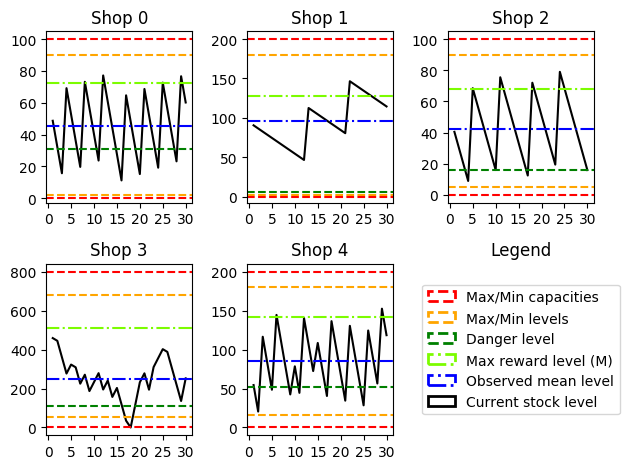

Total discounted rewards Level rewards Transport rewards
-2.6992010895867775 -0.9938383528800809 0.03390457337999998
Average trucks sent:  48.0
1st type Trucks sent to each shop: [array([8, 2, 5, 7, 3, 5])]
2nd type Trucks sent to each shop: [array([ 1,  0,  1, 14,  7,  7])]


In [24]:
test_simulation(simulation_id=16, max_episodes = 10**5,n_episodes = test_episodes)


### Deterministic consumption rates WITH transport/unload costs, 100K episodes 

Test episode: 1
Episode 1 t 0 0.0008928 0.0008928 0.0 5500
Episode 1 t 1 -2.25e-05 0.0005409 0.0005634 4500
Episode 1 t 2 -0.9997279 0.0014742 0.0012021 0200
Episode 1 t 3 -0.0016031 2.82e-05 0.0016313 2400
Episode 1 t 4 -0.0015882 2.15e-05 0.0016096 3300
Episode 1 t 5 0.0004463 0.0004463 0.0 5500
Episode 1 t 6 -0.0001537 0.0010081 0.0011618 0300
Episode 1 t 7 -0.0005506 1.27e-05 0.0005634 4500
Episode 1 t 8 -0.0001067 0.0009396 0.0010463 5300
Episode 1 t 9 -0.0003964 0.0012132 0.0016096 4300
Episode 1 t 10 -2.0003146 -0.9991125 0.0012021 0200
Episode 1 t 11 -1.0015975 -0.9999878 0.0016096 4300
Episode 1 t 12 0.0006987 0.0012838 0.000585 2500
Episode 1 t 13 -0.0014846 0.0001251 0.0016096 4300
Episode 1 t 14 0.0004113 0.0014576 0.0010463 5300
Episode 1 t 15 -1.0011468 -0.999985 0.0011618 0300
Episode 1 t 16 -0.0016033 1.72e-05 0.0016205 1400
Episode 1 t 17 -0.0016155 1.58e-05 0.0016313 2300
Episode 1 t 18 -0.0010391 0.0005705 0.0016096 4300
Episode 1 t 19 -9.03e-05 2.52e-05 0.0001156 05

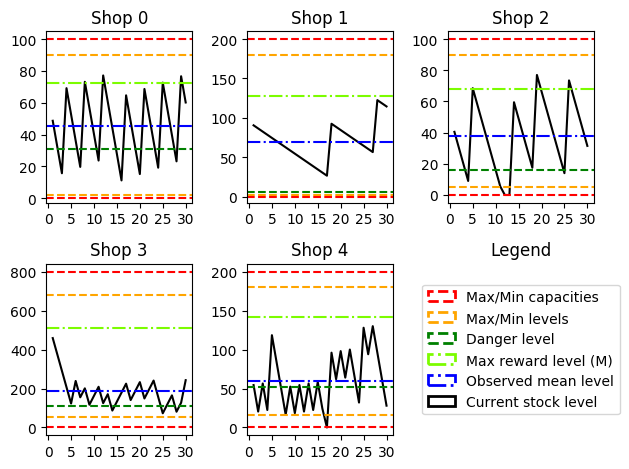

Total discounted rewards Level rewards Transport rewards
-2.030722467010893 -2.9854754479581316 0.032546698259999986
Average trucks sent:  45.0
1st type Trucks sent to each shop: [array([7, 2, 4, 2, 9, 6])]
2nd type Trucks sent to each shop: [array([ 0,  0,  2, 16,  3,  9])]


In [25]:
test_simulation(simulation_id= 17, max_episodes = 100000, n_episodes = test_episodes)

Test episode: 1
Episode 1 t 0 0.0008928 0.0008928 0.0 5500
Episode 1 t 1 -2.25e-05 0.0005409 0.0005634 4500
Episode 1 t 2 -0.9997279 0.0014742 0.0012021 0200
Episode 1 t 3 -1.0010277 -0.9999814 0.0010463 5400
Episode 1 t 4 -0.0016113 2e-05 0.0016313 2300
Episode 1 t 5 -0.0005981 0.0004481 0.0010463 5300
Episode 1 t 6 0.0008911 0.0010066 0.0001156 0500
Episode 1 t 7 -0.0015951 1.45e-05 0.0016096 4300
Episode 1 t 8 -0.0001049 0.0009414 0.0010463 5300
Episode 1 t 9 -0.0013611 0.0002702 0.0016313 2400
Episode 1 t 10 -0.0011365 2.53e-05 0.0011618 0300
Episode 1 t 11 -0.0014327 0.000177 0.0016096 3300
Episode 1 t 12 -0.0005458 1.76e-05 0.0005634 4500
Episode 1 t 13 0.0002204 0.0002204 0.0 5500
Episode 1 t 14 -0.0009902 -0.0004269 0.0005634 4500
Episode 1 t 15 -0.0006213 0.0005405 0.0011618 0300
Episode 1 t 16 -0.0014419 -0.0003956 0.0010463 5300
Episode 1 t 17 -1.0016192 -0.9999879 0.0016313 2300
Episode 1 t 18 -0.0006082 0.0010014 0.0016096 4300
Episode 1 t 19 -0.0011375 2.44e-05 0.0011618 

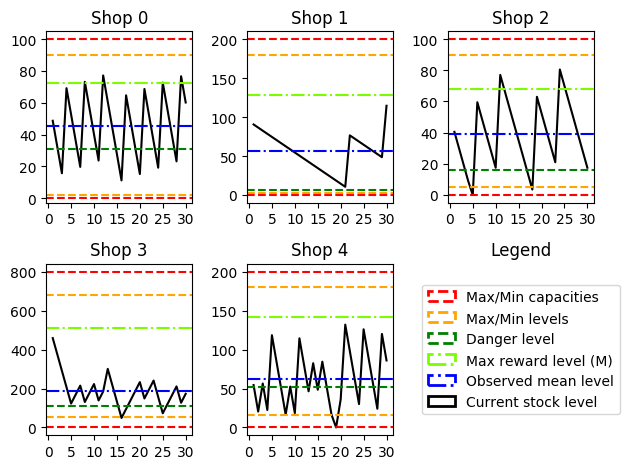

Total discounted rewards Level rewards Transport rewards
-1.7104636269677864 -1.9902228226318375 0.032367161579999984
Average trucks sent:  43.0
1st type Trucks sent to each shop: [array([ 7,  2,  5,  1,  5, 10])]
2nd type Trucks sent to each shop: [array([ 0,  0,  1, 17,  5,  7])]


In [26]:
test_simulation(simulation_id= 18, max_episodes = 100000, n_episodes = test_episodes)

Test episode: 1
Episode 1 t 0 0.0008928 0.0008928 0.0 5500
Episode 1 t 1 -0.9994596 -0.9994596 0.0 5500
Episode 1 t 2 -1.9993561 -1.9993561 0.0 5500
Episode 1 t 3 -2.9999941 -2.9999941 0.0 5500
Episode 1 t 4 -3.0013967 -3.0013967 0.0 5500
Episode 1 t 5 -3.999995 -3.999995 0.0 5500
Episode 1 t 6 -3.9999954 -3.9999954 0.0 5500
Episode 1 t 7 -3.9999957 -3.9999957 0.0 5500
Episode 1 t 8 -3.999996 -3.999996 0.0 5500
Episode 1 t 9 -3.9999963 -3.9999963 0.0 5500
Episode 1 t 10 -3.9999967 -3.9999967 0.0 5500
Episode 1 t 11 -3.999997 -3.999997 0.0 5500
Episode 1 t 12 -3.9999973 -3.9999973 0.0 5500
Episode 1 t 13 -3.9999977 -3.9999977 0.0 5500
Episode 1 t 14 -3.999998 -3.999998 0.0 5500
Episode 1 t 15 -3.9999983 -3.9999983 0.0 5500
Episode 1 t 16 -3.9999986 -3.9999986 0.0 5500
Episode 1 t 17 -3.999999 -3.999999 0.0 5500
Episode 1 t 18 -3.9999993 -3.9999993 0.0 5500
Episode 1 t 19 -3.9999996 -3.9999996 0.0 5500
Episode 1 t 20 -4.0 -4.0 0.0 5500
Episode 1 t 21 -3.9991236 -3.9991236 0.0 5500
Episod

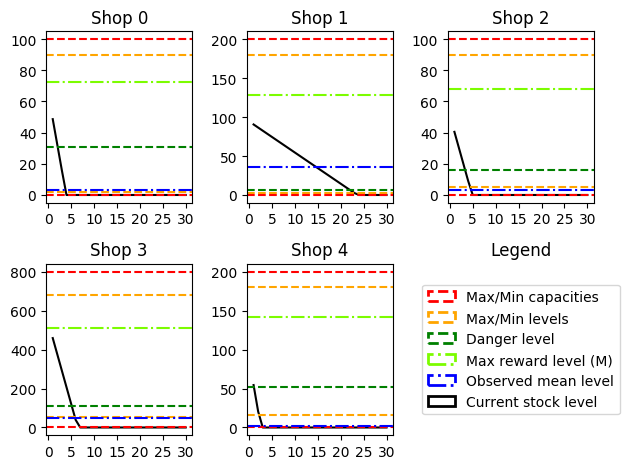

Total discounted rewards Level rewards Transport rewards
-29.159013055074873 -116.99839728499248 0.0
Average trucks sent:  0.0
1st type Trucks sent to each shop: [array([ 0,  0,  0,  0,  0, 30])]
2nd type Trucks sent to each shop: [array([ 0,  0,  0,  0,  0, 30])]


In [27]:
test_simulation(simulation_id= 21, max_episodes = 100000, n_episodes = test_episodes)

Test episode: 1
Episode 1 t 0 0.0008928 0.0008928 0.0 5500
Episode 1 t 1 -2.25e-05 0.0005409 0.0005634 4500
Episode 1 t 2 0.0013586 0.0014742 0.0001156 0500
Episode 1 t 3 -1.0005515 -0.9999881 0.0005634 4500
Episode 1 t 4 -0.0012067 -0.0006216 0.000585 2500
Episode 1 t 5 -1.0001601 -0.9995967 0.0005634 4500
Episode 1 t 6 -0.9993872 -0.9992716 0.0001156 0500
Episode 1 t 7 -1.0005494 -0.999986 0.0005634 4500
Episode 1 t 8 -0.9993392 -0.9993392 0.0 5500
Episode 1 t 9 -0.9994871 -0.9989237 0.0005634 4500
Episode 1 t 10 -1.9995062 -1.9993906 0.0001156 0500
Episode 1 t 11 -5.0011919 -2.9999898 0.0012021 0200
Episode 1 t 12 -2.002222 -2.0011757 0.0010463 5300
Episode 1 t 13 -3.0006738 -1.9998741 0.0007997 2000
Episode 1 t 14 -2.0001022 -1.9999866 0.0001156 0500
Episode 1 t 15 -1.0001048 -0.9995414 0.0005634 4500
Episode 1 t 16 -1.0005533 -0.9999899 0.0005634 4500
Episode 1 t 17 -0.9996096 -0.9996096 0.0 5500
Episode 1 t 18 -2.0102469 -1.0094473 0.0007997 2000
Episode 1 t 19 -2.0000963 -1.9999

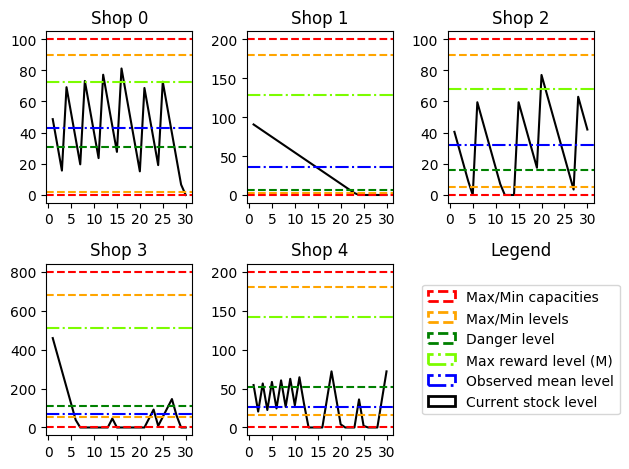

Total discounted rewards Level rewards Transport rewards
-9.640291529646765 -40.31745473667357 0.016906370699999992
Average trucks sent:  32.0
1st type Trucks sent to each shop: [array([ 8,  0,  4,  0, 10,  8])]
2nd type Trucks sent to each shop: [array([ 3,  0,  1,  6,  0, 20])]


In [28]:
test_simulation(simulation_id= 22, max_episodes = 100000, n_episodes = test_episodes)

Test episode: 1
Episode 1 t 0 0.0008928 0.0008928 0.0 5500
Episode 1 t 1 -2.25e-05 0.0005409 0.0005634 4500
Episode 1 t 2 -0.9997279 0.0014742 0.0012021 0200
Episode 1 t 3 -1.0010277 -0.9999814 0.0010463 5400
Episode 1 t 4 -0.0016113 2e-05 0.0016313 2300
Episode 1 t 5 -0.0005981 0.0004481 0.0010463 5300
Episode 1 t 6 0.0008911 0.0010066 0.0001156 0500
Episode 1 t 7 -0.0015951 1.45e-05 0.0016096 4300
Episode 1 t 8 -0.0001049 0.0009414 0.0010463 5300
Episode 1 t 9 -0.0013611 0.0002702 0.0016313 2400
Episode 1 t 10 -0.0011365 2.53e-05 0.0011618 0300
Episode 1 t 11 -0.0014395 0.000181 0.0016205 1300
Episode 1 t 12 -0.0005418 2.16e-05 0.0005634 4500
Episode 1 t 13 -0.0008186 0.0002277 0.0010463 5300
Episode 1 t 14 -0.0009093 0.0007003 0.0016096 4300
Episode 1 t 15 -1.0009604 0.0002417 0.0012021 0200
Episode 1 t 16 -0.0006227 0.0010086 0.0016313 2300
Episode 1 t 17 -0.0005472 1.62e-05 0.0005634 4500
Episode 1 t 18 0.0004468 0.0014931 0.0010463 5300
Episode 1 t 19 -0.0005432 0.0006186 0.00116

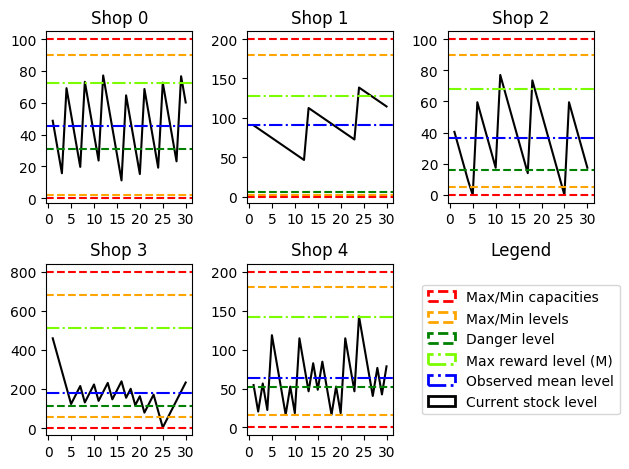

Total discounted rewards Level rewards Transport rewards
-2.015368044627477 -2.987880689689692 0.034057282739999986
Average trucks sent:  45.0
1st type Trucks sent to each shop: [array([7, 2, 5, 0, 7, 9])]
2nd type Trucks sent to each shop: [array([ 0,  0,  3, 17,  4,  6])]


In [29]:
test_simulation(simulation_id= 23, max_episodes = 100000, n_episodes = test_episodes)

### Stochastic consumption rates without transport/unload costs, 100K episodes 

Test episode: 1
Episode 1 t 0 0.0003319 0.0009061 0.0005742 1500
Episode 1 t 1 -0.0004941 0.0005522 0.0010463 5400
Episode 1 t 2 -1.0016118 -0.9999805 0.0016313 2300
Episode 1 t 3 -9.11e-05 2.45e-05 0.0001156 0500
Episode 1 t 4 -0.0015843 2.54e-05 0.0016096 4300
Episode 1 t 5 -0.0001254 0.0004379 0.0005634 4500
Episode 1 t 6 -0.0011308 3.1e-05 0.0011618 0300
Episode 1 t 7 -0.0015781 3.15e-05 0.0016096 4300
Episode 1 t 8 1.91e-05 1.91e-05 0.0 5500
Episode 1 t 9 6.67e-05 0.001113 0.0010463 5300
Episode 1 t 10 -1.000341 -0.9991792 0.0011618 0300
Episode 1 t 11 -0.0015963 3.5e-05 0.0016313 2400
Episode 1 t 12 2.26e-05 2.26e-05 0.0 5500
Episode 1 t 13 -0.0003974 0.0001659 0.0005634 3500
Episode 1 t 14 -0.0009647 0.0006449 0.0016096 4300
Episode 1 t 15 -0.0009587 0.0002031 0.0011618 0300
Episode 1 t 16 -0.0016034 2.79e-05 0.0016313 2400
Episode 1 t 17 -0.001558 6.25e-05 0.0016205 1300
Episode 1 t 18 -0.0004531 0.0005931 0.0010463 5300
Episode 1 t 19 -0.0006742 0.0004877 0.0011618 0300
Episod

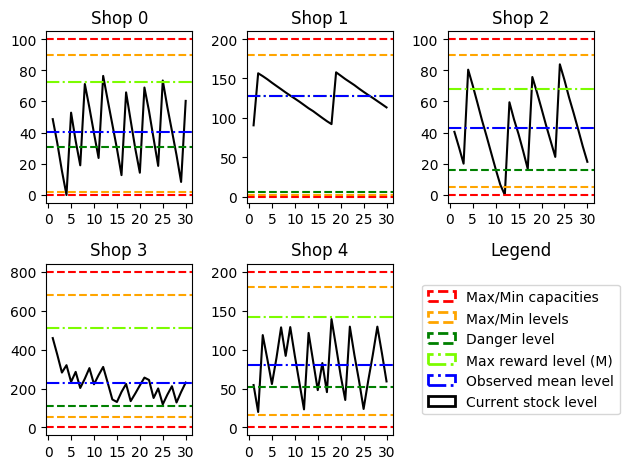

Total discounted rewards Level rewards Transport rewards
-1.165022770935354 -1.9906569445103919 0.030878245319999983
Average trucks sent:  43.0
1st type Trucks sent to each shop: [array([7, 2, 5, 2, 7, 7])]
2nd type Trucks sent to each shop: [array([ 0,  0,  0, 16,  4, 10])]


In [30]:
test_simulation(simulation_id= 14, max_episodes = 100000,n_episodes = test_episodes, noise = True)

Test episode: 1
Episode 1 t 0 0.0003319 0.0009061 0.0005742 1500
Episode 1 t 1 -1.0010641 0.0005455 0.0016096 4400
Episode 1 t 2 -1.0000038 0.0011983 0.0012021 0200
Episode 1 t 3 -0.0014598 0.0001715 0.0016313 2400
Episode 1 t 4 -0.0015859 2.37e-05 0.0016096 3300
Episode 1 t 5 -0.0011455 0.0004641 0.0016096 4300
Episode 1 t 6 -8.62e-05 2.94e-05 0.0001156 0500
Episode 1 t 7 -0.0010242 2.21e-05 0.0010463 5300
Episode 1 t 8 -0.0015889 2.07e-05 0.0016096 4300
Episode 1 t 9 -1.0013385 0.0002928 0.0016313 2400
Episode 1 t 10 -0.0003325 0.0008293 0.0011618 0300
Episode 1 t 11 -0.0015754 3.42e-05 0.0016096 3400
Episode 1 t 12 2.18e-05 2.18e-05 0.0 5500
Episode 1 t 13 -0.0003736 0.0001898 0.0005634 3500
Episode 1 t 14 -0.0009409 0.0006687 0.0016096 4300
Episode 1 t 15 -0.0006305 0.0005314 0.0011618 0300
Episode 1 t 16 -0.0016014 2.99e-05 0.0016313 2400
Episode 1 t 17 -0.0015342 8.63e-05 0.0016205 1300
Episode 1 t 18 -0.0009849 0.0006248 0.0016096 4300
Episode 1 t 19 -0.0011324 2.94e-05 0.001161

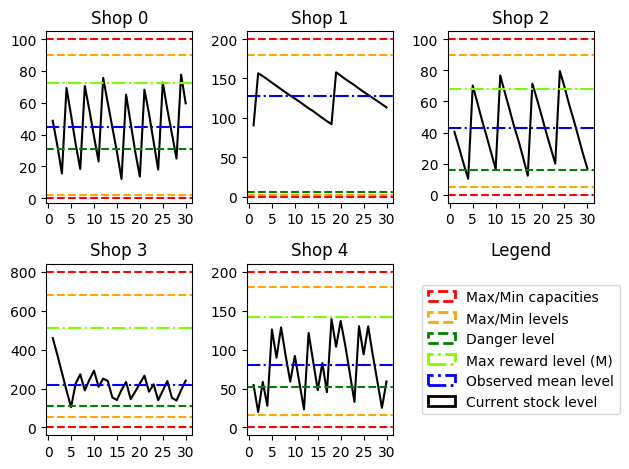

Total discounted rewards Level rewards Transport rewards
-2.1050604955980226 0.008885585024352792 0.03518403017999998
Average trucks sent:  48.0
1st type Trucks sent to each shop: [array([7, 2, 5, 4, 7, 5])]
2nd type Trucks sent to each shop: [array([ 0,  0,  1, 15,  7,  7])]


In [31]:
test_simulation(simulation_id= 24, max_episodes = 100000,n_episodes = test_episodes, noise = True)

### Stochastic consumption rates WITH transport/unload costs, 100K episodes 


Test episode: 1
Episode 1 t 0 -0.0005426 2.08e-05 0.0005634 4500
Episode 1 t 1 -8.9e-06 0.0005545 0.0005634 4500
Episode 1 t 2 -2.0007823 -0.9999826 0.0007997 2000
Episode 1 t 3 -0.0011374 2.44e-05 0.0011618 0300
Episode 1 t 4 -0.0005424 2.09e-05 0.0005634 4500
Episode 1 t 5 -0.0011892 0.0004312 0.0016205 1300
Episode 1 t 6 0.0004661 0.0005817 0.0001156 0500
Episode 1 t 7 -0.0015881 2.16e-05 0.0016096 4300
Episode 1 t 8 -0.0004727 0.0005736 0.0010463 5300
Episode 1 t 9 -0.0013568 0.0002745 0.0016313 2400
Episode 1 t 10 -0.0011292 3.27e-05 0.0011618 0300
Episode 1 t 11 -0.0015804 2.92e-05 0.0016096 3300
Episode 1 t 12 -0.0005387 2.46e-05 0.0005634 4500
Episode 1 t 13 -0.0005013 6.21e-05 0.0005634 4500
Episode 1 t 14 -0.0009627 0.000647 0.0016096 3300
Episode 1 t 15 -2.0007872 -0.9999875 0.0007997 2000
Episode 1 t 16 -0.0002248 0.000937 0.0011618 0300
Episode 1 t 17 -0.0005469 1.65e-05 0.0005634 4500
Episode 1 t 18 -0.0001922 0.0014282 0.0016205 1300
Episode 1 t 19 -1.0011396 -0.9999778 

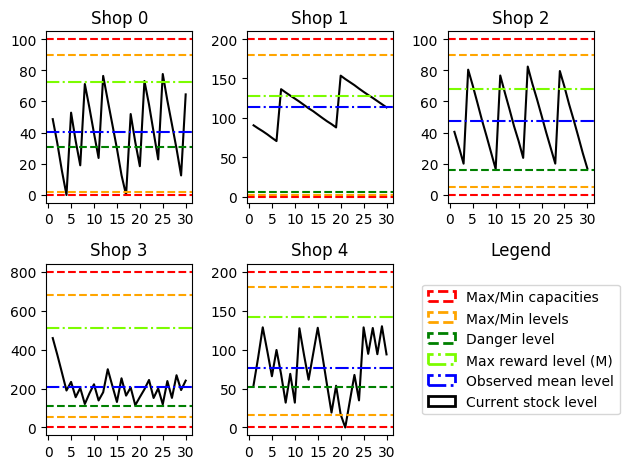

Total discounted rewards Level rewards Transport rewards
-2.220919532625794 -2.992096805313841 0.032595193799999984
Average trucks sent:  49.0
1st type Trucks sent to each shop: [array([ 7,  2,  5,  4, 11,  1])]
2nd type Trucks sent to each shop: [array([ 2,  0,  0, 15,  3, 10])]


In [32]:
test_simulation(simulation_id= 19, max_episodes = 100000,n_episodes = test_episodes, noise = True)

Test episode: 1
Episode 1 t 0 0.0009083 0.0009083 0.0 5500
Episode 1 t 1 -1.67e-05 0.0005467 0.0005634 4500
Episode 1 t 2 -1.0000037 0.0011983 0.0012021 0200
Episode 1 t 3 -1.0014579 -0.9998374 0.0016205 1400
Episode 1 t 4 -0.0016094 2.19e-05 0.0016313 2300
Episode 1 t 5 -0.0005917 0.0004545 0.0010463 5300
Episode 1 t 6 0.0007437 0.0008593 0.0001156 0500
Episode 1 t 7 -0.0017587 -0.0011953 0.0005634 4500
Episode 1 t 8 0.0001633 0.0012095 0.0010463 5300
Episode 1 t 9 -0.0004755 0.0011341 0.0016096 4300
Episode 1 t 10 -1.0001917 0.000608 0.0007997 2000
Episode 1 t 11 -1.0011308 -0.999969 0.0011618 0400
Episode 1 t 12 -0.0022332 -0.0011869 0.0010463 5300
Episode 1 t 13 -0.0004983 0.000548 0.0010463 5300
Episode 1 t 14 -0.0009421 0.0006675 0.0016096 4300
Episode 1 t 15 -0.0006317 0.0005301 0.0011618 0300
Episode 1 t 16 -0.0084292 -0.0068087 0.0016205 1400
Episode 1 t 17 -0.0015462 8.51e-05 0.0016313 2300
Episode 1 t 18 -0.0004305 0.0006157 0.0010463 5300
Episode 1 t 19 -0.0006761 0.0004857

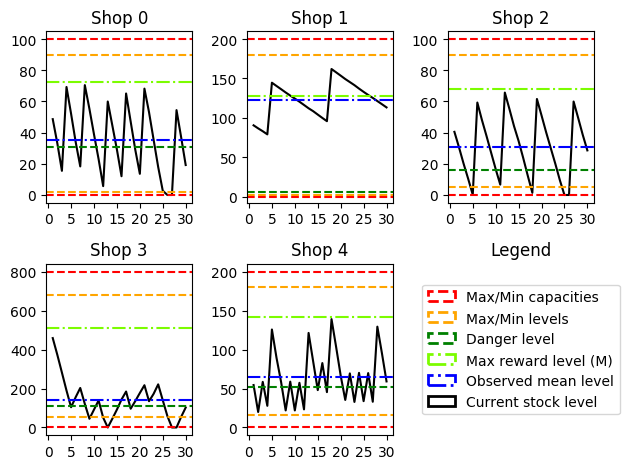

Total discounted rewards Level rewards Transport rewards
-2.9040463492779494 -7.9941635596520335 0.03198332453999998
Average trucks sent:  45.0
1st type Trucks sent to each shop: [array([ 7,  2,  4,  0,  7, 10])]
2nd type Trucks sent to each shop: [array([ 3,  0,  2, 16,  4,  5])]


In [33]:
test_simulation(simulation_id= 20, max_episodes = 100000,n_episodes = test_episodes, noise = True)

Test episode: 1
Episode 1 t 0 0.0003319 0.0009061 0.0005742 1500
Episode 1 t 1 -1.79e-05 0.0005455 0.0005634 4500
Episode 1 t 2 -1.0000038 0.0011983 0.0012021 0200
Episode 1 t 3 -1.0015931 -0.9999835 0.0016096 4300
Episode 1 t 4 -0.0016082 2.31e-05 0.0016313 2400
Episode 1 t 5 -1.0006995 0.0004623 0.0011618 0300
Episode 1 t 6 -8.8e-05 2.76e-05 0.0001156 0500
Episode 1 t 7 -0.001026 2.03e-05 0.0010463 5300
Episode 1 t 8 -0.0001951 0.0008512 0.0010463 5300
Episode 1 t 9 -0.0013335 0.0002978 0.0016313 2400
Episode 1 t 10 -0.0011299 3.2e-05 0.0011618 0300
Episode 1 t 11 -0.0010013 4.49e-05 0.0010463 5300
Episode 1 t 12 -0.0005418 2.16e-05 0.0005634 4500
Episode 1 t 13 -0.0008552 0.000191 0.0010463 5300
Episode 1 t 14 -0.0009396 0.00067 0.0016096 4300
Episode 1 t 15 -2.0006035 -0.9998038 0.0007997 2000
Episode 1 t 16 -0.0002986 0.0008632 0.0011618 0400
Episode 1 t 17 -0.0015861 2.36e-05 0.0016096 3300
Episode 1 t 18 -0.0011581 0.0004515 0.0016096 3300
Episode 1 t 19 0.0003703 0.0004858 0.00

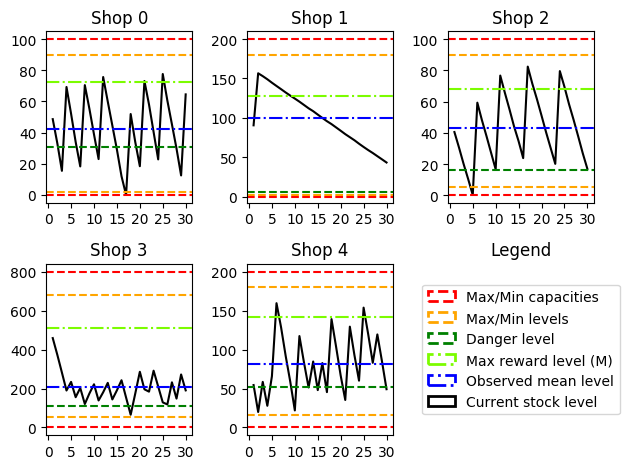

Total discounted rewards Level rewards Transport rewards
-2.5473858102261016 -1.9915548291549412 0.03179966057999998
Average trucks sent:  46.0
1st type Trucks sent to each shop: [array([8, 1, 4, 7, 5, 5])]
2nd type Trucks sent to each shop: [array([ 1,  1,  1, 13,  5,  9])]


In [34]:
test_simulation(simulation_id= 25, max_episodes = 100000,n_episodes = test_episodes, noise = True)

In [35]:
a = '1200'

In [36]:
a[0].count('0')

0

In [37]:
np.zeros(n, dtype = np.int64)

array([0, 0, 0, 0, 0])

In [38]:
int(a[0])

1

Test episode: 1
Episode 1 t 0 -0.0005429 2.05e-05 0.0005634 4500
Episode 1 t 1 -0.0010577 0.000552 0.0016096 4300
Episode 1 t 2 -0.9996692 0.000661 0.0003302 0000
Episode 1 t 3 -0.0005602 2.48e-05 0.000585 2500
Episode 1 t 4 -0.0015855 2.41e-05 0.0016096 4300
Episode 1 t 5 -1.0003707 0.0004073 0.000778 3000
Episode 1 t 6 -0.9990955 0.0016825 0.000778 3000
Episode 1 t 7 -0.0011395 2.23e-05 0.0011618 0400
Episode 1 t 8 -0.001033 1.33e-05 0.0010463 5300
Episode 1 t 9 -0.0013636 0.0002677 0.0016313 2300
Episode 1 t 10 0.0017135 0.0017135 0.0 5500
Episode 1 t 11 -1.000078 -0.9999624 0.0001156 0500
Episode 1 t 12 -2.0030682 -1.0022794 0.0007888 1000
Episode 1 t 13 -0.0003401 0.0012696 0.0016096 4300
Episode 1 t 14 -0.000914 0.0006956 0.0016096 4300
Episode 1 t 15 -0.0004386 0.0007232 0.0011618 0300
Episode 1 t 16 -0.0116095 -0.0099782 0.0016313 2300
Episode 1 t 17 -0.0016017 1.88e-05 0.0016205 1400
Episode 1 t 18 -0.001047 0.0005627 0.0016096 3300
Episode 1 t 19 -0.9997539 0.0005762 0.000330

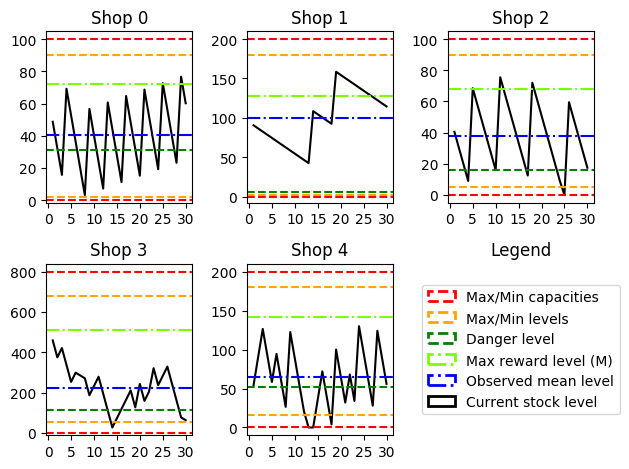

Total discounted rewards Level rewards Transport rewards
-3.1066420051464445 -2.997897824452652 0.03157059653999998
Average trucks sent:  49.0
1st type Trucks sent to each shop: [array([7, 2, 6, 5, 6, 4])]
2nd type Trucks sent to each shop: [array([ 5,  0,  0, 14,  4,  7])]


In [39]:
test_simulation(simulation_id= 27, max_episodes = 1000,n_episodes = test_episodes, noise = False)